In [1]:
############ imports ###############
import xarray as xr
import numpy as np
import pandas as pd
from eofs.xarray import Eof

import sys
import os

/home/m/m300883/miniconda3/envs/thirdPanel/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [3]:
from numpy.random import normal
from scipy.stats import norm

In [4]:
import seaborn as sns

In [5]:
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.path as mpath
from matplotlib.colorbar import Colorbar

import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)


In [6]:
import scipy

In [7]:
import matplotlib as mpl
mpl.rcParams['mpl_toolkits.legacy_colorbar'] = False

/tmp/ipykernel_2497344/466364334.py:2: MatplotlibDeprecationWarning: 
The mpl_toolkits.legacy_colorbar rcparam was deprecated in Matplotlib 3.4 and will be removed two minor releases later.
  mpl.rcParams['mpl_toolkits.legacy_colorbar'] = False


# Seasonal pattern

## season data

In [8]:
season_data = xr.open_dataset('/work/mh0033/from_Mistral/mh0033/m300883/task1/Hist_obs/obs/Season/pre-processed/detrend.nc')

In [9]:
season_data

<xarray.Dataset>
Dimensions:    (time: 42, bnds: 2, lon: 70, lat: 32)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1981-01-01 ... 2021-01-01
  * lon        (lon) float64 -90.0 -88.12 -86.25 -84.38 ... 35.62 37.5 39.38
  * lat        (lat) float64 79.27 77.41 75.54 73.68 ... 27.05 25.18 23.32 21.45
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    var151     (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Tue Feb 22 15:13:01 2022: cdo -detrend djf.nc detrend.nc\nT...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [10]:
season_data = season_data.var151/100.0

## weights

In [11]:
coslat = np.cos(np.deg2rad(season_data.lat)).clip(0., 1.)
wgts = np.sqrt(coslat.values)[..., np.newaxis]

# Do EOF and Projection

In [12]:
# function to calculate coefficent to change the sign of the data    
def coefcal(eof):
    data = eof
    # NAO
    coef_NAO = data.sel(lat = slice(90,60),lon = slice(-70,-10),mode = 'NAO').mean(dim = ['lat','lon'])<0
    coef_NAO = (2*coef_NAO-1)  # to make 1 to 1 , 0 to -1

    # EA
    coef_EA = data.sel(lat = slice(65,45),lon = slice(-40,40),mode = 'EA').mean(dim = ['lat','lon'])<0
    coef_EA = (2*coef_EA-1)

    return xr.concat([coef_NAO,coef_EA],dim = 'mode')

In [13]:
def standardizex(data):
    time_mean = data.mean(dim = 'time')
    time_std = data.std(dim = 'time')
    return (data-time_mean)/time_std

In [14]:
solver = Eof(season_data,weights = wgts,center=True)

In [15]:
eofs = solver.eofs(neofs =2)

In [16]:
eofs['mode'] = ['NAO','EA']

In [17]:
pcs = solver.pcs(npcs = 2)

In [18]:
pcs['mode']= ['NAO','EA']

In [19]:
eof_dw = eofs/wgts

# standarize
std_pc = pcs.std(dim = 'time') #(mode)
eof_stded = eof_dw*std_pc

In [20]:
coef = coefcal(eofs)

In [21]:
eof_stded = eof_stded*coef

In [22]:
pcs_stded = standardizex(pcs)

In [23]:
pcs_stded=pcs_stded*coef

In [24]:
fra = solver.varianceFraction(neigs = 2)

In [25]:
fra['mode'] = ['NAO','EA']

# visu

In [26]:
def axbuild(ax):
    
    theta = np.linspace(0,2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.coastlines()
    gl=ax.gridlines(crs = ccrs.PlateCarree(),draw_labels=False)
    gl.xformatter = LongitudeFormatter()
    gl.xlocator = mticker.FixedLocator(np.arange(-180,180,45))

    gl.ylocator = mticker.FixedLocator([20,40,60])
    gl.yformatter = LatitudeFormatter()

    ax.set_extent([-180,180,20,90],crs = ccrs.PlateCarree())
    ax.get_extent(crs = ccrs.PlateCarree())

In [27]:
EOFs_show = eof_stded

In [28]:
proj = ccrs.Orthographic(central_longitude=-20, central_latitude=60)

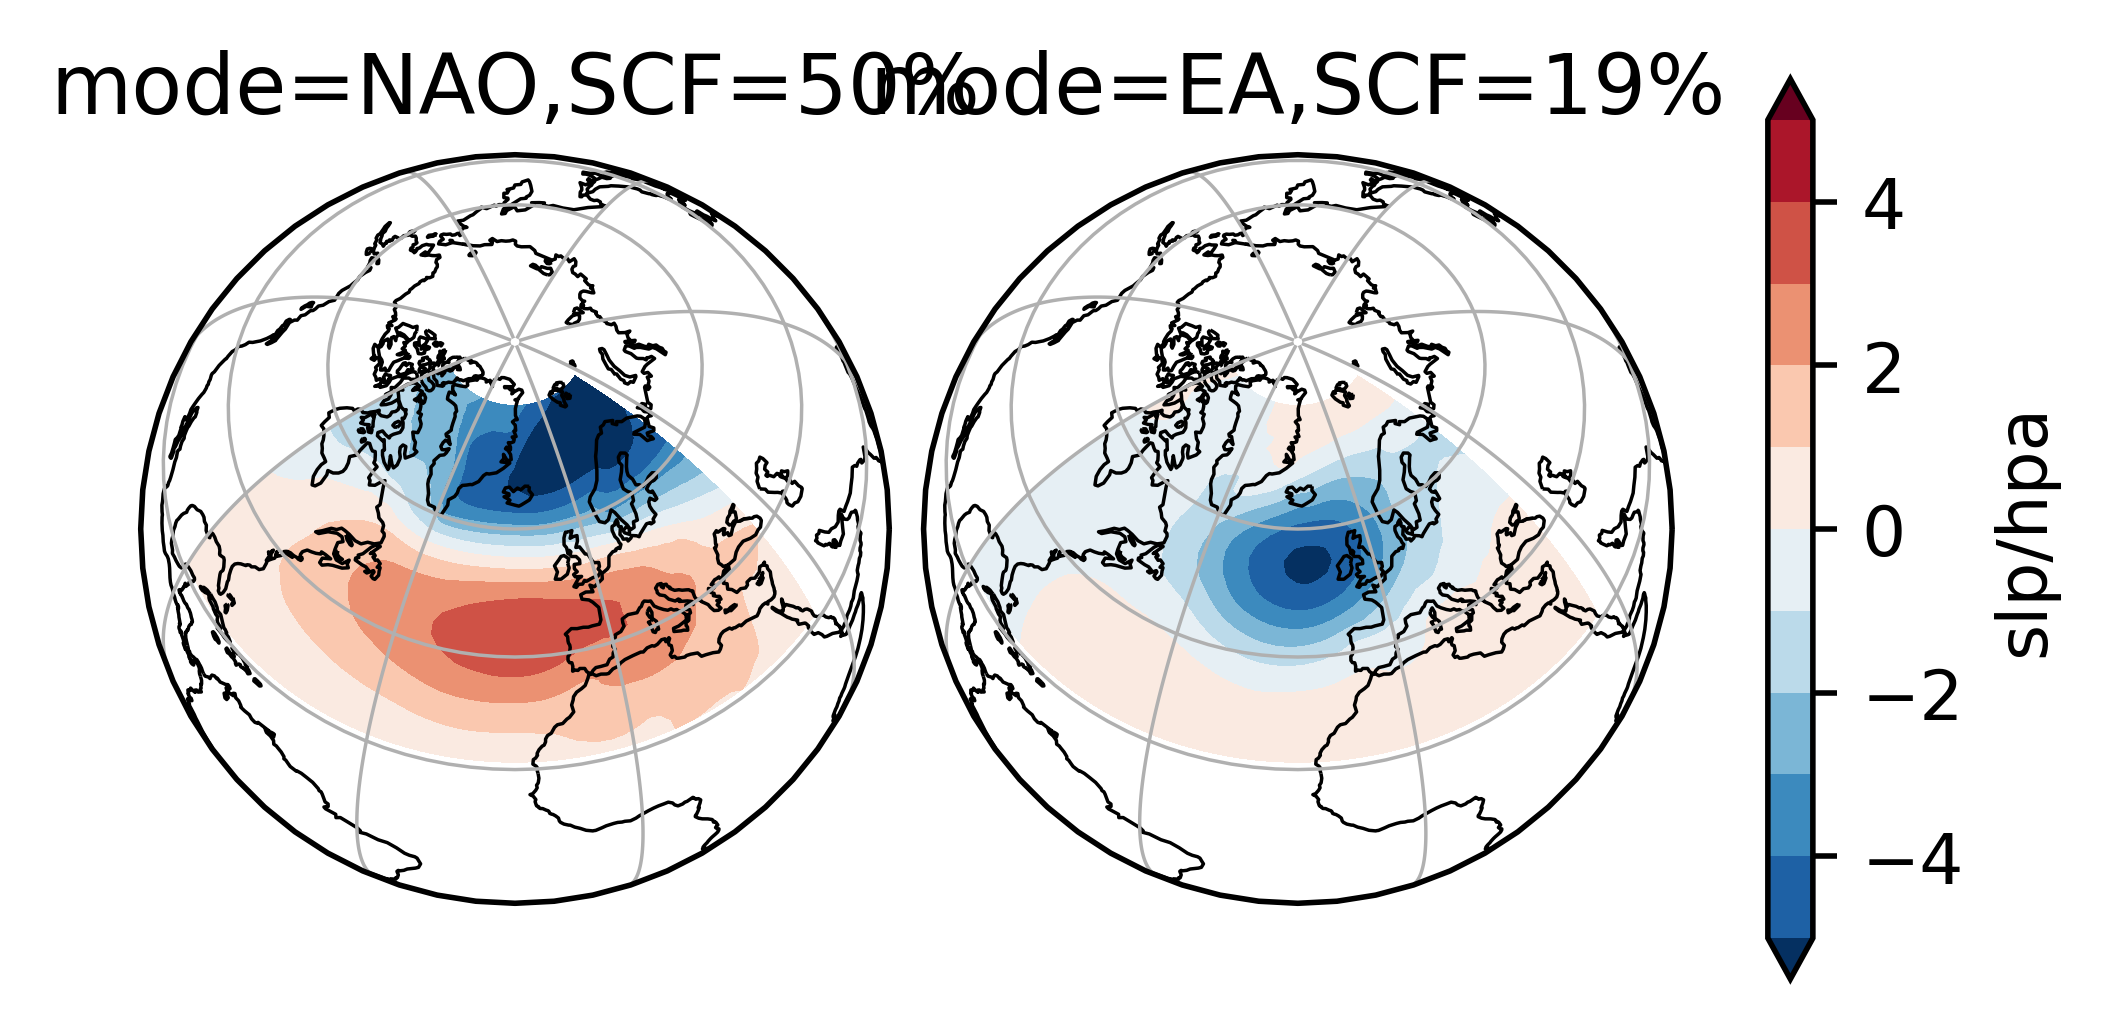

In [40]:
EOFmaps = EOFs_show.plot.contourf('lon','lat',col = 'mode',
                                      levels = np.arange(-5,5.1,1.0),
                                      extend = 'both',
                                      subplot_kws=dict(projection = proj
                                                     )
                                      ,transform = ccrs.PlateCarree(),add_colorbar = True )

for i,ax in enumerate(EOFmaps.axes.reshape(-1)):
    # axbuild(ax)
    ax.set_global()
    ax.coastlines(linewidth=0.5)
    gl=ax.gridlines(crs = ccrs.PlateCarree(),draw_labels=False,
                   linewidth = 0.5)
    gl.xformatter = LongitudeFormatter(zero_direction_label=False)
    gl.xlocator = mticker.FixedLocator(np.arange(-180,180,45))

    gl.ylocator = mticker.FixedLocator([20,40,60])
    gl.yformatter = LatitudeFormatter()
    
    scf = "{:.0%}".format(fra[i].values)
    ax.set_title(f'mode={EOFs_show.mode[i].values},SCF={scf}')
    
    
fig = EOFmaps.fig
fig.set_figheight(3)
fig.set_figwidth(6)
fig.set_dpi(500)
EOFmaps.cbar.set_label("slp/hpa")
# plt.savefig("/work/mh0033/m300883/retreat_2022/spatial_pattern_obs_proj.png",dpi = 500)



In [29]:
pcs_stded['time'] = pcs_stded['time'].dt.year

In [30]:
pcs_stded.name = 'pcs'

In [31]:
df_pcs = pcs_stded.to_dataframe().reset_index()

In [32]:
df_pcs = df_pcs.set_index('time')

In [33]:
df_pcs

,mode,pcs
time,,
1980,NAO,-0.594107
1980,EA,0.302920
1981,NAO,0.569940
1981,EA,-1.518806
1982,NAO,-1.037286
...,...,...
2019,EA,-0.408180
2020,NAO,1.492903
2020,EA,1.558731


Text(0, 0.5, 'std')

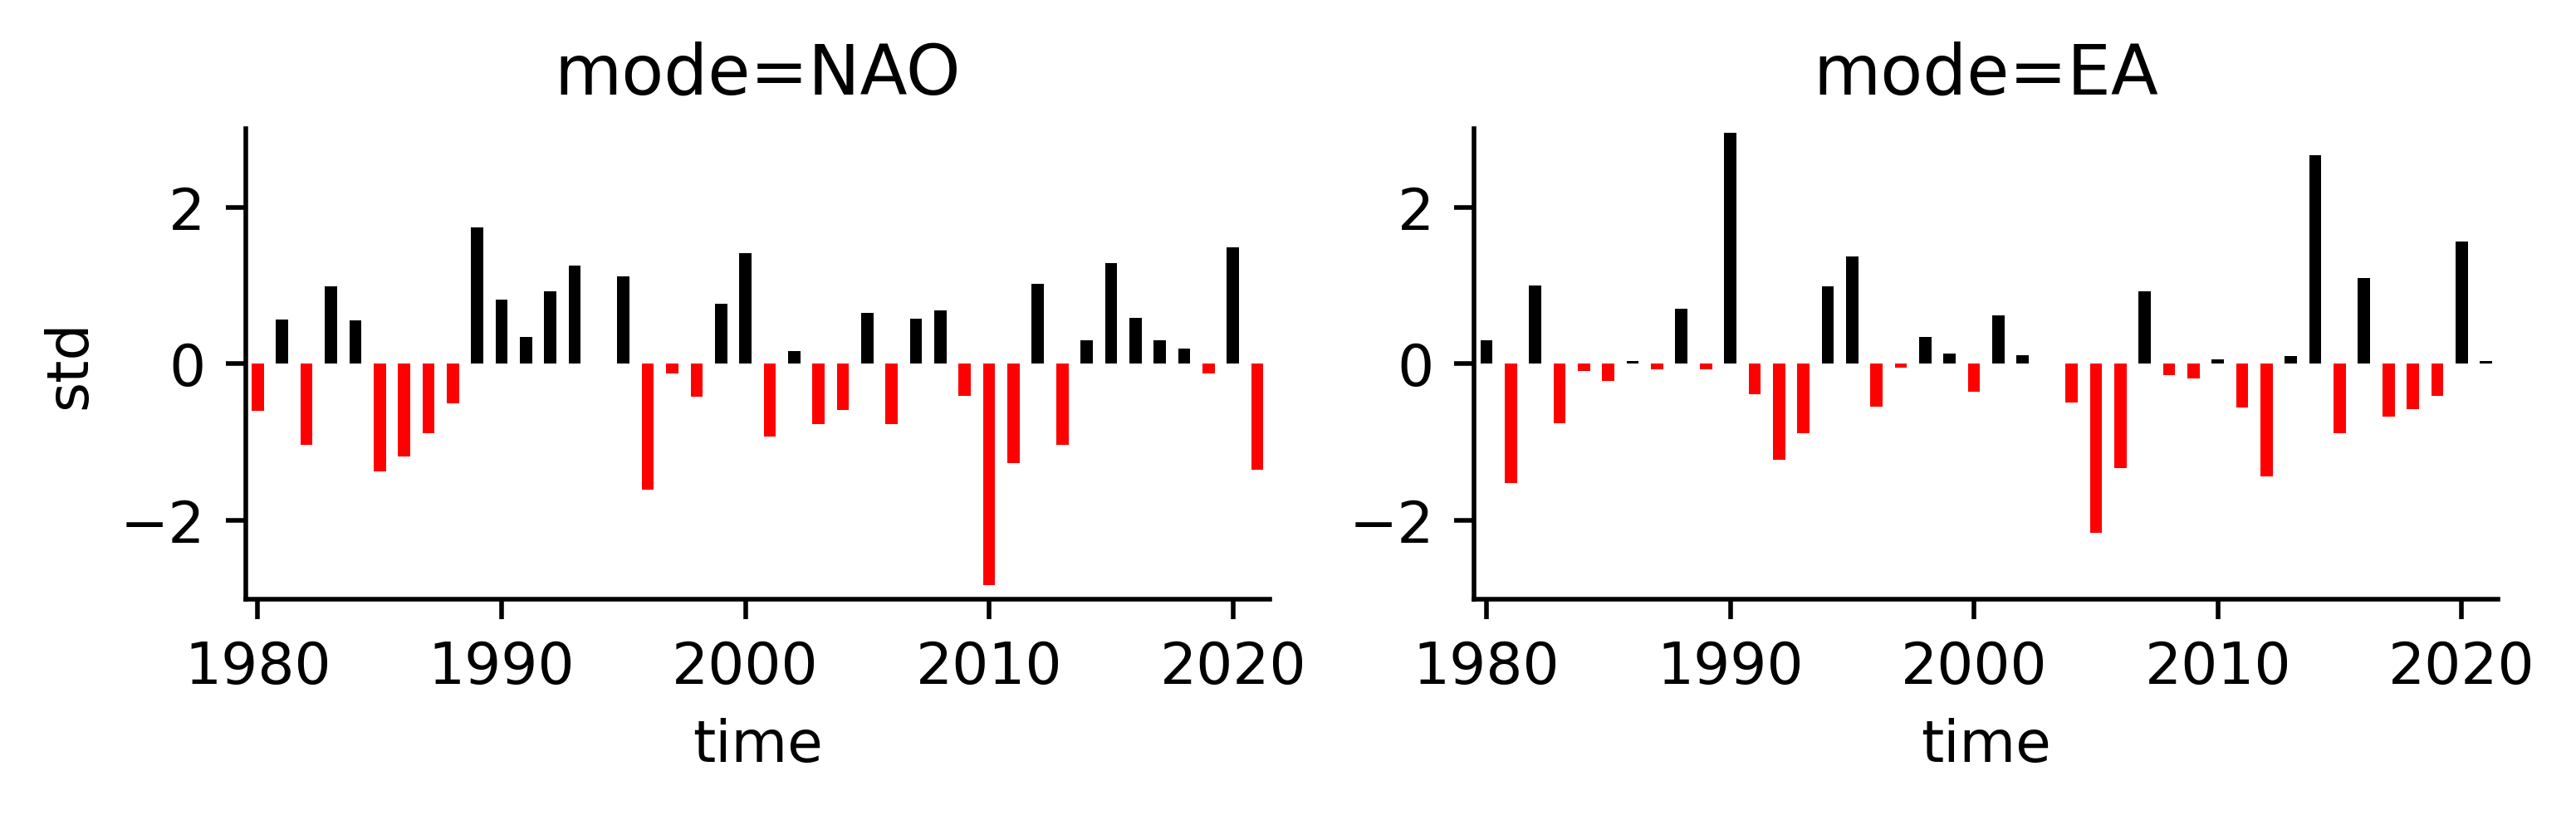

In [41]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
fig,ax = plt.subplots(1,2,figsize = (7,1.5),dpi = 500)
data = df_pcs[df_pcs['mode']=='NAO']
data['pcs'].plot(kind='bar', rot=0,
                    color=(data['pcs'] > 0).map({True: 'k',
                                                    False: 'r'}),ax = ax[0])
ax[0].xaxis.set_major_locator(MultipleLocator(10))


data = df_pcs[df_pcs['mode']=='EA']
data['pcs'].plot(kind='bar',rot=0,
                    color=(data['pcs'] > 0).map({True: 'k',
                                                    False: 'r'}),ax = ax[1])
ax[1].xaxis.set_major_locator(MultipleLocator(10))

ax[0].set_ylim(-3,3)
ax[1].set_ylim(-3,3)
ax[0].set_title('mode=NAO')
ax[1].set_title('mode=EA')

for a in ax:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['bottom'].set_visible(True)
    a.spines['left'].set_visible(True)    
ax[0].set_ylabel('std')
# plt.savefig("/work/mh0033/m300883/retreat_2022/index_obs.png",dpi = 500)

